<a href="https://colab.research.google.com/github/koolganni/data-analysis-practice/blob/master/spotify-music-popularity-prediction-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> 글로벌 음악 시장의 최신 트렌드를 반영한 노래를 데이터 분석과 머신러닝 모델을 통해 만들 수 있을까?



**[요약]**

- **비즈니스 문제 :** 올해 하반기에 글로벌 음악 시장을 겨냥한 노래를 발표하고자 합니다.

- **해결 방안 :** 최신 글로벌 음악 트렌드를 분석해서 유의미한 특징을 찾아내 신곡 기획 및 작곡에 반영하고 (레퍼런스 제공) 노래가 글로벌 음악 시장에서 히트 칠 가능성이 있을지 예측해 봅니다.

- **데이터 :**  Spotify(스포티파이) 2010~2021 매년 인기곡 2000개의 최신 인기 데이터

- **컬럼**은 아티스트명, 노래 제목, 발표 시기, 음악적 특징들, 인기도 (최신 재생 횟수 정보 반영된 정보이자 모델의 타겟)

- **가설 :** "인기 있는 노래가 갖고 있는 유의미한 특성이 있을 것이다."

- **모델 선정 :** 이진 분류 모델

- **타겟 :** True(히트 가능성 있음) False(보통)

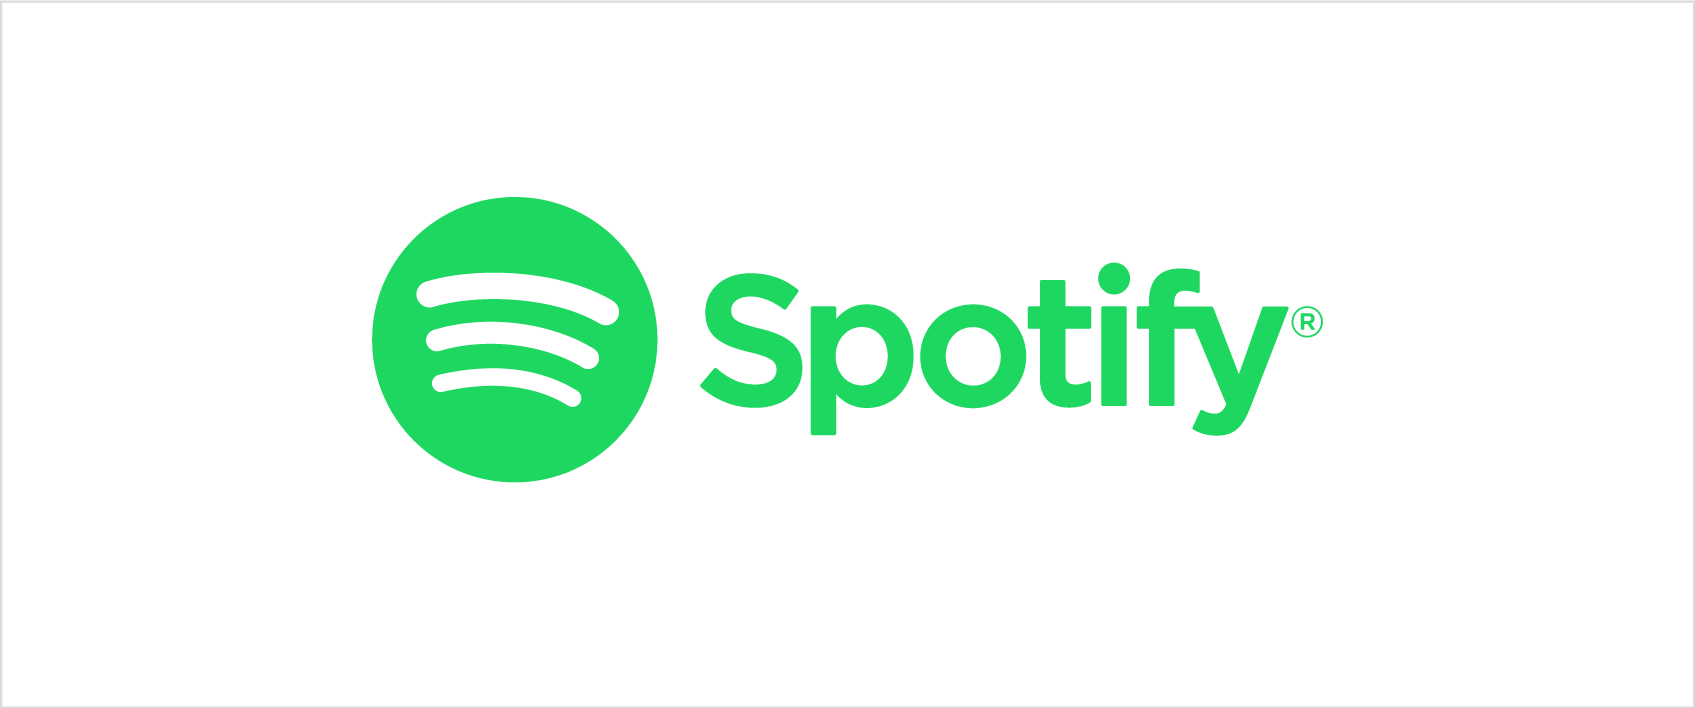

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

In [3]:
# 데이터 불러오기
from google.colab import files
import io

uploaded = files.upload()
df_track = pd.read_csv(io.BytesIO(uploaded['spotify_songs_data.csv']))
df_track.head()

Saving spotify_songs_data.csv to spotify_songs_data.csv


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.0330,['Hogsnort Rupert'],0.430,176853,0.876,0,7MrfBf2RmFjNyON1l9VK28,0.000000,9,0.3100,-6.353,1,I Love to Boogie (2006),1,2010,0.0782,177.700,0.964,2010
1,0.0190,['Davenport'],0.628,212033,0.820,0,0NbiKlHDAhYuNsErI4dQGz,0.068500,7,0.0696,-7.300,1,No Other Man,0,2010,0.0482,149.826,0.634,2010
2,0.0595,['Chris Mills'],0.658,254240,0.631,0,4QdxDMHe7sH7O3QMsjoOW0,0.000028,7,0.1880,-6.121,1,Suicide Note,0,2010,0.0357,82.239,0.711,2010
3,0.1470,['Maroon 5'],0.603,226507,0.618,0,2t2CoOfwakFAexhvMmWtTb,0.000000,3,0.1050,-5.098,1,Just A Feeling,49,2010,0.0284,149.955,0.295,2010
4,0.0302,['Never Shout Never'],0.684,170560,0.622,1,5YX2R55h76mamgXwsvBRlH,0.000001,2,0.2770,-5.313,1,Can't Stand It,49,2010,0.0334,125.974,0.368,2010


In [4]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28589 entries, 0 to 28588
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      28589 non-null  float64
 1   artists           28589 non-null  object 
 2   danceability      28589 non-null  float64
 3   duration_ms       28589 non-null  int64  
 4   energy            28589 non-null  float64
 5   explicit          28589 non-null  int64  
 6   id                28589 non-null  object 
 7   instrumentalness  28589 non-null  float64
 8   key               28589 non-null  int64  
 9   liveness          28589 non-null  float64
 10  loudness          28589 non-null  float64
 11  mode              28589 non-null  int64  
 12  name              28589 non-null  object 
 13  popularity        28589 non-null  int64  
 14  release_date      28589 non-null  object 
 15  speechiness       28589 non-null  float64
 16  tempo             28589 non-null  float6

## EDA와 데이터 전처리

In [5]:
# 데이터셋 파악
from pandas_profiling import ProfileReport

profile = ProfileReport(df_track, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- 중복 데이터 제거 
  - id 컬럼 제외 하고 중복 데이터 제거 (같은 노래로 봐도 무방) *가장 높은 popularity 를 갖는 관측치만 남기기



In [6]:
def drop_duplicate_track(df):
  df['track'] = df['artists'] + df['name']
  indices = []

  for track in df['track'].unique():
    subset = df[(df['track'] == track)]
    if len(subset) == 1:
      continue
    max_pop = subset['popularity'].max() # 중복 노래 중 가장 높은 popularity
    index = subset[(subset['popularity'] == max_pop)].index[0] 
    indices.append(index)

  df_temp = df.loc[indices]

  df.drop(columns=['id', 'track'], inplace=True)
  df = df[(~df.duplicated() == 1)]

  df_temp.drop(columns=['id', 'track'], inplace=True)
  df = pd.concat([df, df_temp]).drop_duplicates().reset_index(drop=True)

  return df

In [7]:
df_track = drop_duplicate_track(df_track)

- 범주형 데이터 처리
  - EDA 과정에서 의미를 파악할 수 있도록 변형

In [8]:
def get_categorical_features(df):
  # key
  mapping = {
      0: 'C', 1: 'C#/Db', 2: 'D', 3: 'D#/Eb', 4: 'E', 5: 'F', 6: 'F#/Gb', 
      7: 'G', 8: 'G#/Ab', 9: 'A', 10: 'A#/Bb', 11: 'B'
  }
  df['key'].replace(mapping, inplace=True)

  # mode
  df['mode'].replace({0: 'minor', 1: 'major'}, inplace=True)

  # explicit
  df['explicit'].replace({0: 'False', 1: 'True'}, inplace=True)

  return df

In [9]:
df_eda = df_track.copy()
df_eda = get_categorical_features(df_eda)

In [10]:
df_eda.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.0330,['Hogsnort Rupert'],0.430,176853,0.876,False,0.000000,A,0.3100,-6.353,major,I Love to Boogie (2006),1,2010,0.0782,177.700,0.964,2010
1,0.0190,['Davenport'],0.628,212033,0.820,False,0.068500,G,0.0696,-7.300,major,No Other Man,0,2010,0.0482,149.826,0.634,2010
2,0.0595,['Chris Mills'],0.658,254240,0.631,False,0.000028,G,0.1880,-6.121,major,Suicide Note,0,2010,0.0357,82.239,0.711,2010
3,0.1470,['Maroon 5'],0.603,226507,0.618,False,0.000000,D#/Eb,0.1050,-5.098,major,Just A Feeling,49,2010,0.0284,149.955,0.295,2010
4,0.0302,['Never Shout Never'],0.684,170560,0.622,True,0.000001,D,0.2770,-5.313,major,Can't Stand It,49,2010,0.0334,125.974,0.368,2010


In [11]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26247 entries, 0 to 26246
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      26247 non-null  float64
 1   artists           26247 non-null  object 
 2   danceability      26247 non-null  float64
 3   duration_ms       26247 non-null  int64  
 4   energy            26247 non-null  float64
 5   explicit          26247 non-null  object 
 6   instrumentalness  26247 non-null  float64
 7   key               26247 non-null  object 
 8   liveness          26247 non-null  float64
 9   loudness          26247 non-null  float64
 10  mode              26247 non-null  object 
 11  name              26247 non-null  object 
 12  popularity        26247 non-null  int64  
 13  release_date      26247 non-null  object 
 14  speechiness       26247 non-null  float64
 15  tempo             26247 non-null  float64
 16  valence           26247 non-null  float6

- EDA
  - 히트곡 확인
  - 데이터 분포 확인
  - coefficient (heatmap) 확인 → 상관관계 유추

In [12]:
# 최신 히트곡 확인
df_eda.groupby('name')['popularity'].mean().sort_values(ascending=False).head(15)

name
drivers license                    100.0
Mood (feat. iann dior)              96.0
positions                           96.0
Whoopty                             94.0
LA NOCHE DE ANOCHE                  94.0
Therefore I Am                      94.0
34+35                               94.0
WITHOUT YOU                         94.0
DÁKITI                              93.0
you broke me first                  93.0
What You Know Bout Love             93.0
WAP (feat. Megan Thee Stallion)     92.0
Anyone                              92.0
HOLIDAY                             92.0
Lonely (with benny blanco)          92.0
Name: popularity, dtype: float64

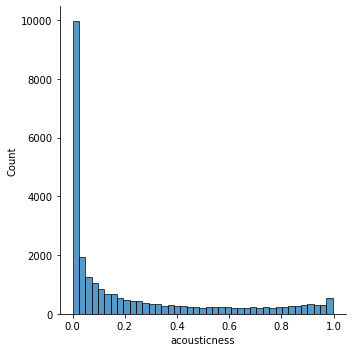

In [13]:
# 데이터 분포 및 이상치 확인
sns.displot(df_eda['acousticness']);

👉 어쿠스틱이 아닌 노래가 훨씬 많습니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

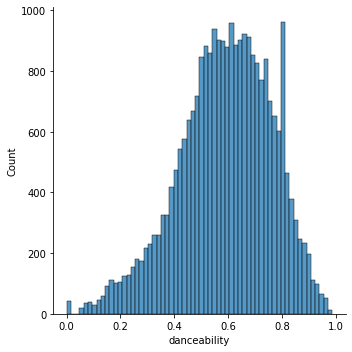

In [14]:
sns.displot(df_eda['danceability']);

👉 댄스곡임을 나타내는 특성은 정규분포에 가까운 모습입니다. 대체로 댄스가 가능한 노래가 더 많습니다. danceability 가 0인 노래도 있습니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

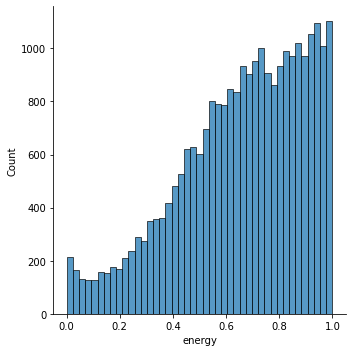

In [15]:
sns.displot(df_eda['energy']);

👉 energy 가 강한, 즉 긴장감 있고 액티브한 노래가 많습니다. 다소 left skewed 된 분포의 모습입니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

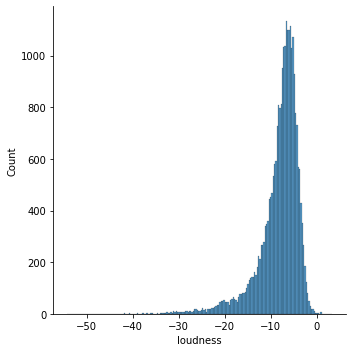

In [16]:
sns.displot(df_eda['loudness']);

👉 노래의 dB(데시벨)을 나타내는 loudness 특성은 -10 에서 0 사이의 음원이 많습니다. left skewed 된 분포의 모습입니다. 일반적인 노래의 데시벨 범위는 -60에서 0이므로 특별한 이상치는 없어 보입니다.

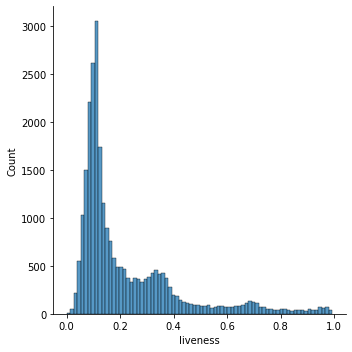

In [17]:
sns.displot(df_eda['liveness']);

👉 노래에서 라이브로 들리는 부분의 비중을 나타내는 liveness 특성의 분포를 보면, 약 0.1인 노래가 많습니다. 즉, 거의 라이브로 들리지 않고 녹음된 음원인 것이 많은 것으로 보입니다. 0.8이 넘어가는 음원도 존재합니다. 콘서트 버전 음원 같은 것은 이에 해당할 것으로 추측됩니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

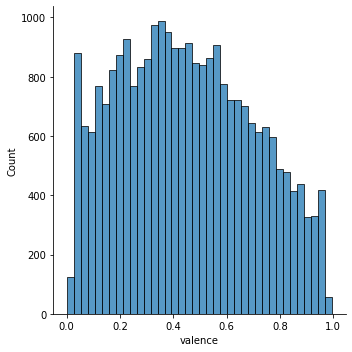

In [18]:
sns.displot(df_eda['valence']);

👉 높은 valence 는 노래가 happy, cheerful, euphoric 하고 낮은 valence 는 노래가 sad, depressed, angry 함을 나타냅니다. 음원으로 등록된 노래는 valence 가 낮은 노래가 좀 더 많아 보입니다. 0.1인 음원도 다수 있으나 대체로 valence 가 중간인 노래가 많이 존재합니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

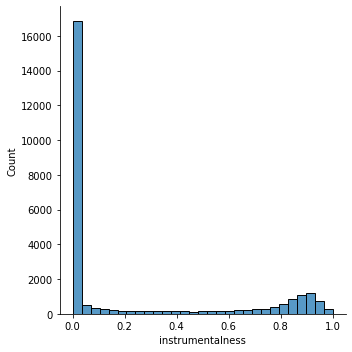

In [19]:
sns.displot(df_eda['instrumentalness']);

👉 instrumentalness 가 0인, 가사가 있는 노래가 많습니다. 보컬이 따로 없는 노래도 존재합니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

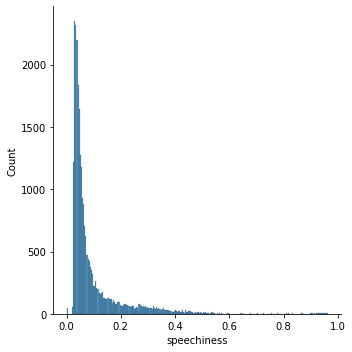

In [20]:
sns.displot(df_eda['speechiness']);

👉 노래에 speech 가 포함된 음원은 많이 없는 것으로 보입니다. right skewed 된 분포의 모습입니다. 0~1 구간 내에 데이터가 잘 분포하고 있고 이상치는 따로 없어 보입니다.

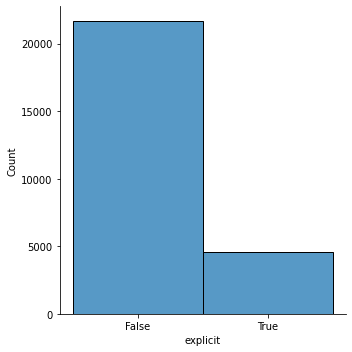

In [21]:
sns.displot(df_eda['explicit']);

👉 노래 가사에 자극적인 내용이 포함된 노래는 그렇지 않은 노래의 개수의 25%에 못 미치는 양을 가지고 있습니다.

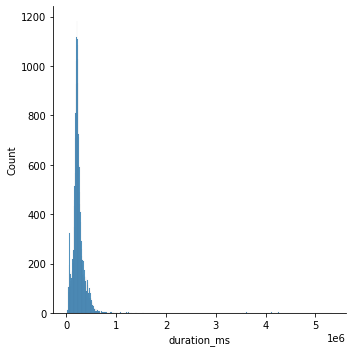

In [22]:
sns.displot(df_eda['duration_ms']);

👉 노래의 길이가 1,000,000 ms (약 16분) 이내인 음원이 많이 보입니다. 그 이상인 데이터도 존재하는데 약 80분의 길이를 갖는 음원도 있습니다. 일반적인 음원의 길이와는 거리가 멀어 보이는데, 콘서트 풀버전 음원 같은 걸까요? 혹은 클래식 음악 중 하나일까요? duration 이 긴 음원들을 좀 더 살펴보겠습니다.

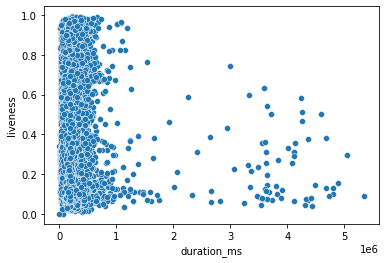

In [23]:
sns.scatterplot(data=df_eda, x='duration_ms', y='liveness');

👉 duration 이 긴 음원 중 라이브인 음원이 많지는 않아 보입니다. 대부분 liveness 가 0.6 아래인 음원들입니다.

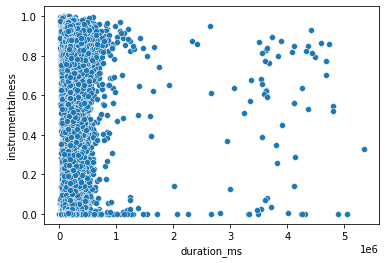

In [24]:
sns.scatterplot(data=df_eda, x='duration_ms', y='instrumentalness');

👉 duration 이 긴 음원 중 inst 인 음원은 존재하나, duration 이 짧은 음원보다 많은 양은 아닙니다.

In [25]:
# 노래 길이가 16분이 넘는 음원의 개수
len(df_track[df_eda['duration_ms'] > 1000000])

112

👉 위 그래프들에서는 데이터가 주로 0~1,000,000ms 사이의 duration 을 갖고 있습니다. 1,000,000ms 를 넘는 음원의 개수는 112개로 이상치로 취급해서 제거해도 큰 문제는 없어 보입니다.

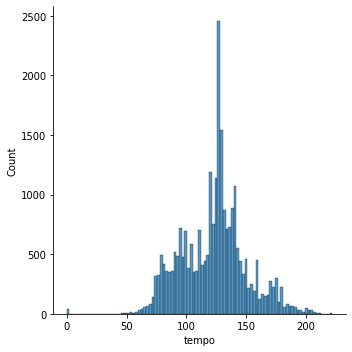

In [26]:
sns.displot(df_eda['tempo']);

👉 노래의 템포(BPM)는 약 125 BPM이 가장 많은 정규 분포에 가까운 모습을 보이고 있습니다. 0 BPM도 보이는데, 이는 노래의 빠르기가 0이라는 의미로 논리적으로 맞지 않아 보입니다.

In [27]:
len(df_track[df_eda['tempo'] == 0])

43

👉 템포가 0인 음원이 43개 존재합니다. 이상치로 간주하고 제거하는 것이 좋겠습니다.

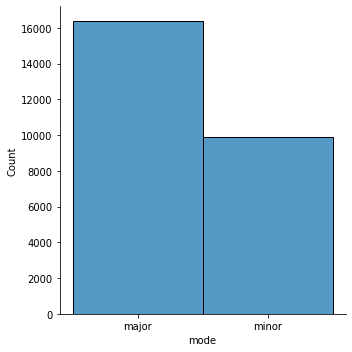

In [28]:
sns.displot(df_eda['mode']);

👉 Major(장조)로 시작하는 노래가 더 많습니다. Minor(단조)로 시작하는 노래는 장조로 시작하는 노래의 반을 조금 넘는 양입니다.

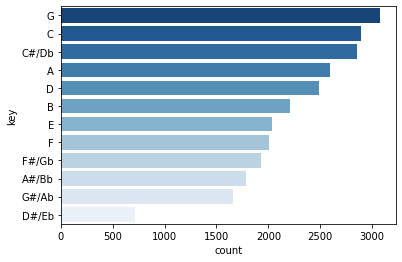

In [29]:
order = df_eda['key'].value_counts().index
sns.countplot(data=df_eda, y='key', order=order, palette='Blues_r');

👉 노래의 메인 Key 가 G, C, C# 순으로 가장 많습니다. D# 이 메인 Key 인 노래가 가장 적습니다.

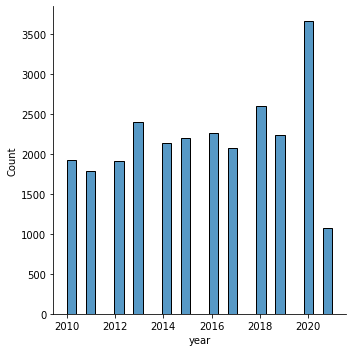

In [30]:
sns.displot(df_eda['year']);

👉 음원 발매 연도가 2010~2021 가 존재합니다. 2020년의 데이터가 가장 많습니다. 2021년은 아직 데이터가 많이 쌓이지 않아 상대적으로 적어 보입니다.

- 데이터 전처리
  - 학습에 필요 없는 데이터 제거
  - 이상치 제거
  - 데이터 단위 변경

In [31]:
def preprocess(df):
  # 학습에 필요 없는 데이터 제거 ('name', 'release_date')
  df.drop(columns=['name', 'release_date'], inplace=True)

  # 이상치 제거
  # 노래 길이(duration_ms) : 16분이 넘으면 제거
  df.drop(df[(df['duration_ms'] > 1000000)].index, inplace=True)
  # 노래 빠르기(tempo) : 0이면 제거
  df.drop(df[(df['tempo'] == 0)].index, inplace=True)

  # duration_ms -> duration_m : 노래 길이를 ms 단위가 아닌 m(분) 단위로 변경
  df['duration_m'] = df['duration_ms'] / (1000*60)
  df.drop(columns=['duration_ms'], inplace=True)

  return df

In [32]:
df_track = preprocess(df_track)

In [33]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26092 entries, 0 to 26246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      26092 non-null  float64
 1   artists           26092 non-null  object 
 2   danceability      26092 non-null  float64
 3   energy            26092 non-null  float64
 4   explicit          26092 non-null  int64  
 5   instrumentalness  26092 non-null  float64
 6   key               26092 non-null  int64  
 7   liveness          26092 non-null  float64
 8   loudness          26092 non-null  float64
 9   mode              26092 non-null  int64  
 10  popularity        26092 non-null  int64  
 11  speechiness       26092 non-null  float64
 12  tempo             26092 non-null  float64
 13  valence           26092 non-null  float64
 14  year              26092 non-null  int64  
 15  duration_m        26092 non-null  float64
dtypes: float64(10), int64(5), object(1)
memo

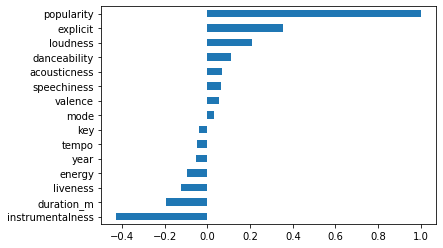

In [34]:
# 타겟과 특성의 상관계수
df_track.corr().loc['popularity'].sort_values().plot.barh();

👉 Numerical 데이터 중에는 타겟인 popularity 를 제외하고 explicit(가사에 자극적인 내용 포함), loudness(데시벨 크기), danceability(댄스에 어울리는 정도) 등의 특성이 타겟과 양의 상관관계를 보이며, 반대로 instrumentalness(가사 없는 정도), duration_m(노래 길이) 등의 특성이 타겟과 음의 상관관계를 보입니다.

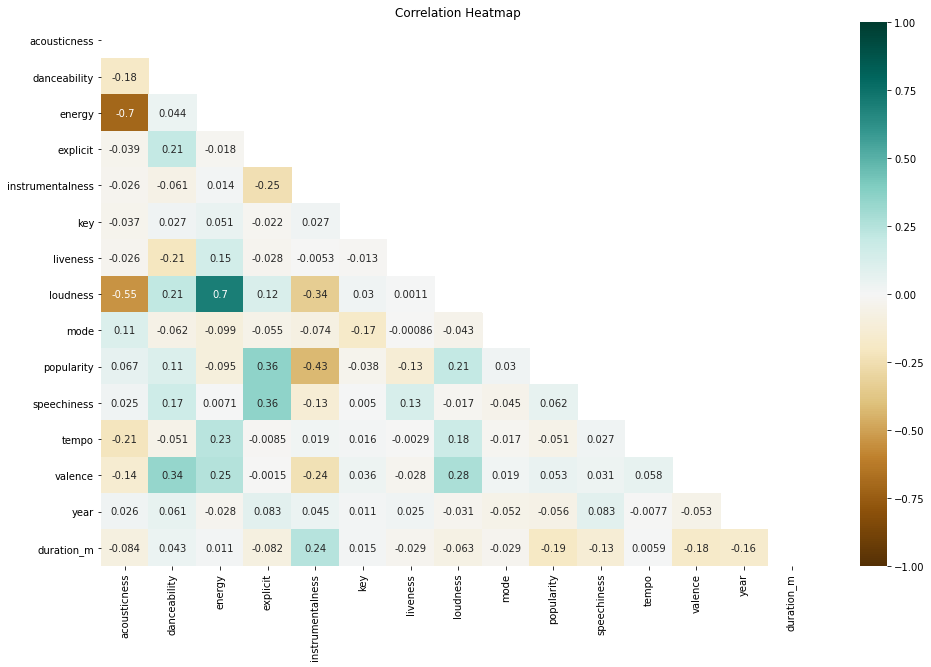

In [35]:
# 전체 Coefficient 확인
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(df_track.corr(), dtype=np.bool))
sns.heatmap(df_track.corr(), vmin=-1, vmax=1, annot=True, mask=mask, cmap='BrBG').set_title('Correlation Heatmap');

👉 타겟을 제외한 나머지 특성들 사이에서도 상관관계가 있습니다.
- 데시벨이 높을수록 댄스곡에 어울리는 노래이고 노래의 분위기가 밝은 느낌입니다.
- 노래 길이가 길수록 가사가 없는 Inst. 버전의 노래일 가능성이 있습니다.
- 데시벨이 높고 템포도 빨라질수록 노래에 긴장감이 있고 액티브한 것을 알 수 있습니다.

- Data leakage 확인

👉 데이터의 타겟을 제외한 나머지 특성들의 경우 타겟 정보 누수를 만들만한 것은 없어 보입니다. 모두 타겟 정보를 얻기 이전에 알 수 있는 정보들입니다.

- Feature Engineering
  - 필요한 데이터 타입 변환
  - 새로운 유의미한 피처 추가, 필요 없는 피처 제거

>'장르'도 노래의 매우 중요한 특성이라 생각합니다. 따라서 현재 데이터와 유사한 피처를 갖고 있는 '장르 데이터'를 가져와서 매핑해보도록 하겠습니다.

In [36]:
# 장르 데이터 추가
uploaded = files.upload()
df_genre = pd.read_csv(io.BytesIO(uploaded['genres_data.csv']))
df_genre.head()

Saving genres_data.csv to genres_data.csv


,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1


각 장르가 가지고 있는 일반적인 음악적 특징에 대한 데이터로 acousticness, danceability, energy, tempo 등 기존 스포티파이 노래 데이터와 유사한 피처를 갖고 있습니다. 이 데이터를 기반으로 스포티파이 노래의 장르 특성을 예측해서 추가해보고 싶습니다.

In [37]:
df_genre['duration_m'] = df_genre['duration_ms'] / (1000*60)
df_genre.drop(columns=['duration_ms'], inplace=True)

In [38]:
genre_columns = df_genre.columns.drop(['genres', 'popularity', 'key', 'mode'])
X_genre_train = df_genre[genre_columns]
X_genre_test = df_track[genre_columns]
y_genre_train = df_genre[['genres']]

In [39]:
from sklearn.neighbors import KNeighborsClassifier

genre_clf = KNeighborsClassifier()
genre_clf.fit(X_genre_train, np.ravel(y_genre_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
y_genre_pred = genre_clf.predict(X_genre_test)
y_genre_pred

array(['argentine metal', 'mod revival', 'boston indie', ...,
       'classic czech pop', 'contemporary classical piano',
       'barockinterpreten'], dtype=object)

In [41]:
genres = y_genre_pred.T
df_track['genre'] = genres
df_track.head()

,acousticness,artists,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_m,genre
0,0.0330,['Hogsnort Rupert'],0.430,0.876,0,0.000000,9,0.3100,-6.353,1,1,0.0782,177.700,0.964,2010,2.947550,argentine metal
1,0.0190,['Davenport'],0.628,0.820,0,0.068500,7,0.0696,-7.300,1,0,0.0482,149.826,0.634,2010,3.533883,mod revival
2,0.0595,['Chris Mills'],0.658,0.631,0,0.000028,7,0.1880,-6.121,1,0,0.0357,82.239,0.711,2010,4.237333,boston indie
3,0.1470,['Maroon 5'],0.603,0.618,0,0.000000,3,0.1050,-5.098,1,49,0.0284,149.955,0.295,2010,3.775117,australian ska
4,0.0302,['Never Shout Never'],0.684,0.622,1,0.000001,2,0.2770,-5.313,1,49,0.0334,125.974,0.368,2010,2.842667,australian metal


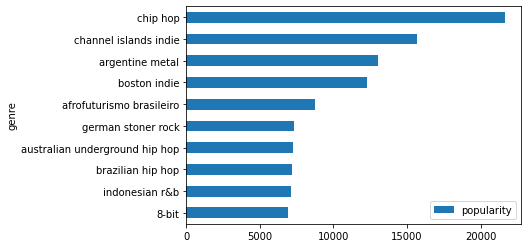

In [42]:
# 인기 장르 확인 (2010~2021 나온 노래)
genre_grp = df_track.groupby(['genre'])
genre_top = genre_grp[['popularity']].sum().sort_values(by=['popularity'], ascending=False)[:10]
genre_top.sort_values(by=['popularity']).plot.barh();

👉 힙합 장르 중 하나인 chip hop 이 가장 큰 누적 popularity 를 가지고 있습니다. 그 다음으로는 인디, 메탈 장르, 락 장르, 다른 종류의 힙합 장르, R&B 장르가 있습니다.

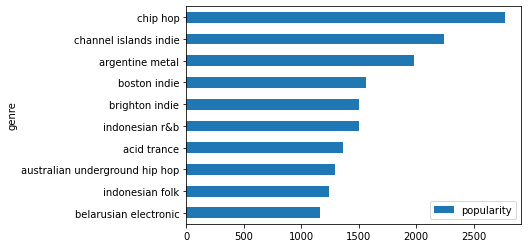

In [43]:
# 인기 장르 확인 (2020 노래)
genre_grp = df_track[(df_track['year'] == 2020)].groupby(['genre'])
genre_top = genre_grp[['popularity']].sum().sort_values(by=['popularity'], ascending=False)[:10]
genre_top.sort_values(by=['popularity']).plot.barh();

👉 2020년에 발표한 노래 중에는 여전히 힙합, 인디, 메탈, R&B 장르가 강세이지만, 포크와 일렉트로닉 장르 또한 작년에 인기가 많았음을 알 수 있습니다.

In [44]:
len(df_track['genre'].unique())

1457

1457개의 높은 cardinality 를 줄이기 위해, KMeans Clustering 을 활용해서 장르를 군집화해보고자 합니다. 그리고 그 이후에 노래 데이터에 군집화된 장르를 매핑해보겠습니다.

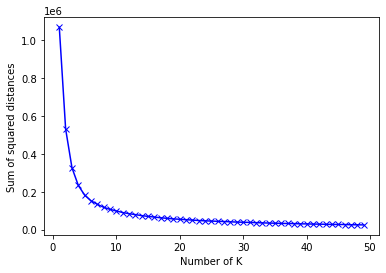

In [45]:
from sklearn.cluster import KMeans 

# 적절한 k 값 찾기
sum_of_squared_distances = []
K = range(1, 50)
for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(df_genre[genre_columns])
  sum_of_squared_distances.append(km.inertia_)

plt.xlabel('Number of K')
plt.ylabel('Sum of squared distances')
plt.plot(K, sum_of_squared_distances, 'bx-');

In [46]:
# 10개의 장르 군집
km = KMeans(n_clusters=10)
genres_pred = km.fit_predict(df_track[genre_columns])
genres_pred

array([5, 7, 1, ..., 1, 9, 0], dtype=int32)

In [47]:
df_track['genre'] = genres_pred.T
df_track.head()

,acousticness,artists,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_m,genre
0,0.0330,['Hogsnort Rupert'],0.430,0.876,0,0.000000,9,0.3100,-6.353,1,1,0.0782,177.700,0.964,2010,2.947550,5
1,0.0190,['Davenport'],0.628,0.820,0,0.068500,7,0.0696,-7.300,1,0,0.0482,149.826,0.634,2010,3.533883,7
2,0.0595,['Chris Mills'],0.658,0.631,0,0.000028,7,0.1880,-6.121,1,0,0.0357,82.239,0.711,2010,4.237333,1
3,0.1470,['Maroon 5'],0.603,0.618,0,0.000000,3,0.1050,-5.098,1,49,0.0284,149.955,0.295,2010,3.775117,7
4,0.0302,['Never Shout Never'],0.684,0.622,1,0.000001,2,0.2770,-5.313,1,49,0.0334,125.974,0.368,2010,2.842667,0


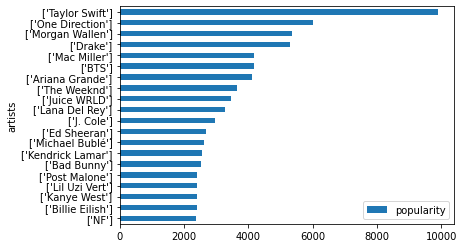

In [48]:
# 인기 아티스트 확인 (2010~2021 나온 노래)
artists_grp = df_track.groupby(['artists'])
artists_top = artists_grp[['popularity']].sum().sort_values(by=['popularity'], ascending=False)[:20]
artists_top.sort_values(by=['popularity']).plot.barh();

👉 아티스트 별로 노래의 popularity 를 누적한 결과 상위 20개입니다. Taylor Swift 가 압도적인 popularity 누적량을 가집니다. 2010년 부터의 데이터인만큼 비교적 최근에 히트곡을 꾸준히 냈었던 아티스트들이 보입니다. 아티스트 별로 popularity 가 유의미한 차이를 가지고 있는 것으로 추측됩니다. 

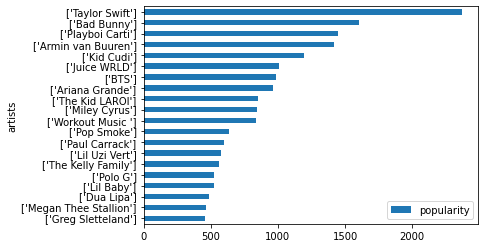

In [49]:
# 인기 아티스트 확인 (2020 노래)
artists_grp = df_track[(df_track['year'] == 2020)].groupby(['artists'])
artists_top = artists_grp[['popularity']].sum().sort_values(by=['popularity'], ascending=False)[:20]
artists_top.sort_values(by=['popularity']).plot.barh();

👉 2020년에 발표한 노래 중에는 여전히 Taylor Swift 가 1위이지만, Bad Bunny, Playboi Carti 등 새로운 아티스트도 보입니다.  

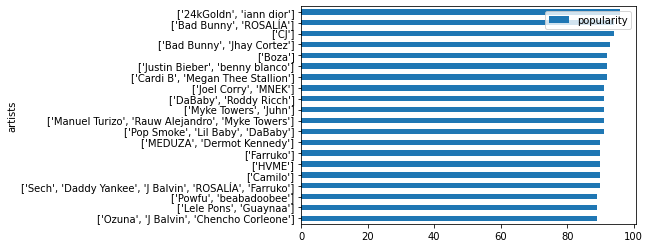

In [50]:
# 인기 아티스트 확인 (2010~2021 나온 노래 '평균')
artists_grp = df_track.groupby(['artists'])
artists_top = artists_grp[['popularity']].mean().sort_values(by=['popularity'], ascending=False)[:20]
artists_top.sort_values(by=['popularity']).plot.barh();

👉 노래 인기의 평균으로 살펴보면, 콜라보를 통해 노래를 발표한 아티스트들이 대부분입니다. 콜라보를 통해 더 새롭고 완성도 있는 작업으로 유저들로부터 반짝 높은 인기를 얻은 노래들로 추측됩니다.

In [51]:
def feature_engineer(df):
  # 타입 변환
  df['key'] = df['key'].astype(str)
  df['genre'] = df['genre'].astype(str) # 이후 더미 인코딩

  # 유의미한 데이터 추가
  # artists_popularity 특성을 추가하고 artists 특성은 드롭 -> 데이터 누수를 일으킴
  # artists_grp = df.groupby(['artists'])
  # artists_pop = artists_grp[['popularity']].sum()
  # artists_pop.rename(columns={'popularity': 'artists_popularity'}, inplace=True)
  
  # df = df.merge(artists_pop, on='artists')
  df.drop(columns=['artists'], inplace=True)

  return df

In [52]:
df_track = feature_engineer(df_track)

In [53]:
df_track.head()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_m,genre
0,0.0330,0.430,0.876,0,0.000000,9,0.3100,-6.353,1,1,0.0782,177.700,0.964,2010,2.947550,5
1,0.0190,0.628,0.820,0,0.068500,7,0.0696,-7.300,1,0,0.0482,149.826,0.634,2010,3.533883,7
2,0.0595,0.658,0.631,0,0.000028,7,0.1880,-6.121,1,0,0.0357,82.239,0.711,2010,4.237333,1
3,0.1470,0.603,0.618,0,0.000000,3,0.1050,-5.098,1,49,0.0284,149.955,0.295,2010,3.775117,7
4,0.0302,0.684,0.622,1,0.000001,2,0.2770,-5.313,1,49,0.0334,125.974,0.368,2010,2.842667,0


In [54]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26092 entries, 0 to 26246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      26092 non-null  float64
 1   danceability      26092 non-null  float64
 2   energy            26092 non-null  float64
 3   explicit          26092 non-null  int64  
 4   instrumentalness  26092 non-null  float64
 5   key               26092 non-null  object 
 6   liveness          26092 non-null  float64
 7   loudness          26092 non-null  float64
 8   mode              26092 non-null  int64  
 9   popularity        26092 non-null  int64  
 10  speechiness       26092 non-null  float64
 11  tempo             26092 non-null  float64
 12  valence           26092 non-null  float64
 13  year              26092 non-null  int64  
 14  duration_m        26092 non-null  float64
 15  genre             26092 non-null  object 
dtypes: float64(10), int64(4), object(2)
memo

- 베이스라인 모델 확인

In [55]:
# 0~49, 50~100 -> 0, 1
df_track['popularity_score'] = np.where(df_track['popularity'] < 60, 0, 1)

In [56]:
df_track['popularity_score'].value_counts(normalize=True).sort_index()

0    0.716235
1    0.283765
Name: popularity_score, dtype: float64

## 머신러닝 모델 구축

- 머신러닝 모델 개발 (베이스라인 모델과도 비교)
  - 결정 트리
  - 랜덤 포레스트
  - XGBoost

In [57]:
# train, val, test 데이터로 분리 (60/20/20)
# popularity 특성이 최신 인기 지표 데이터(ex. 재생 횟수)를 기반으로 한번에 산출한 결과이므로 무작위로 나눠도 무방
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_track, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.25, random_state=2)

In [58]:
# 데이터에서 features, target 분리
target = 'popularity_score'
features = df_track.columns.drop([target, 'popularity'])

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]

In [59]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)

pipe.fit(X_train, y_train)
print('훈련 정확도 :', pipe.score(X_train, y_train))
print('검증 정확도 :', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 : 0.9990417784591797
검증 정확도 : 0.7654723127035831


👉 베이스라인 모델보다 나은 성능을 보여줍니다. 또한 훈련 데이터셋에 과적합되었음을 예상할 수 있습니다.

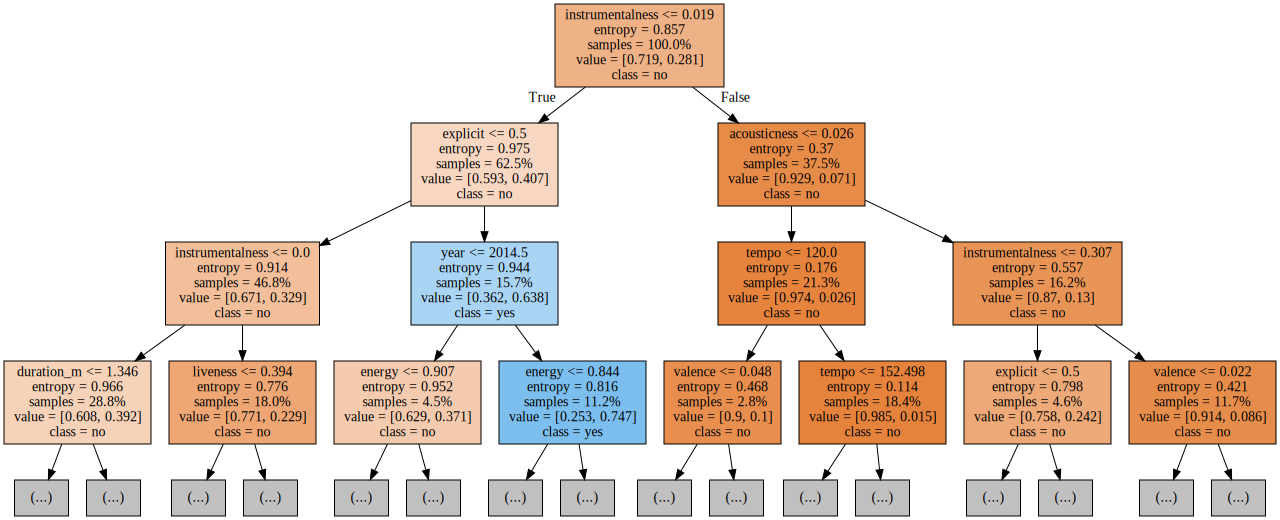

In [60]:
import graphviz
from sklearn.tree import export_graphviz

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

graph_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(graph_data))

👉 데이터 누수를 일으키는 특성은 특별히 없어 보입니다. 결정 트리 모델에서는 노래에서 가사가 차지하는 정도, 가사의 내용 그리고 어쿠스틱한 노래인지가 노래의 인기를 예측하는데 중요한 기준으로 사용되는 것을 알 수 있습니다.

In [61]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

pipe2 = make_pipeline(
    OneHotEncoder(),
    RandomForestClassifier(n_estimators=300, random_state=2, n_jobs=-1)
)

pipe2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['key', 'genre'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estim

In [62]:
# 모델 평가
from sklearn.metrics import classification_report

y_pred_val = pipe2.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      3742
           1       0.77      0.53      0.63      1477

    accuracy                           0.82      5219
   macro avg       0.80      0.74      0.76      5219
weighted avg       0.82      0.82      0.81      5219



👉 클래스 1에 대한 재현율이 상대적으로 낮습니다. 다만 현재 풀고자 하는 문제의 경우 '히트 칠 노래가 아닌데 히트를 칠 것이다' 라고 예측할 경우의 비용 낭비가 더 크므로 정밀도가 좀 더 중요하다고 볼 수 있기 때문에 치명적인 문제는 아닙니다.

In [63]:
# Xgboost Classifier
from xgboost import XGBClassifier

pipe3 = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(n_estimators=300, random_state=2, n_jobs=-1)
)

pipe3.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['key', 'genre'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=300, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=2,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
    

In [64]:
# 모델 평가
y_pred_val = pipe3.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3742
           1       0.75      0.61      0.67      1477

    accuracy                           0.83      5219
   macro avg       0.80      0.76      0.78      5219
weighted avg       0.83      0.83      0.83      5219



👉 이전 랜덤 포레스트 모델보다 f1-score, accuracy 점수가 향상되었습니다.

In [65]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe3.predict_proba(X_val)[:, -1]
print('AUC score :', roc_auc_score(y_val, y_pred_proba))

AUC score : 0.8849624402969168


- 머신러닝 모델 튜닝
  - RandomSearchCV
  - 최종 모델 test 점수

In [66]:
from sklearn.model_selection import RandomizedSearchCV

pipe4 = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(random_state=2, n_jobs=-1)
)

params = { # 하이퍼파라미터
    'xgbclassifier__n_estimators': [100, 300, 500],
    'xgbclassifier__max_depth': [10, 15, None]
}

clf = RandomizedSearchCV(
    pipe4,
    params,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=False,
                                                            verbose=0)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_byleve

In [67]:
clf.best_params_

{'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 500}

In [68]:
# 하이퍼파라미터 튜닝 후 AUC 점수
y_pred_proba = clf.predict_proba(X_val)[:, -1]
print('AUC score :', roc_auc_score(y_val, y_pred_proba))

AUC score : 0.8906453379034379


👉 하이퍼파라미터 튜닝 후 AUC 점수가 향상되었습니다.

In [69]:
# 모델 평가 (테스트셋)
y_pred_proba = clf.predict_proba(X_test)[:, -1]
print('AUC score :', roc_auc_score(y_test, y_pred_proba))

AUC score : 0.8775455488459445


👉 AUC 점수를 기준으로 좋은 모델인 것으로 판단할 수 있습니다.

- 머신러닝 모델 해석
  - PDP
  - SHAP
  - 어떤 특성이 필요할지
  - 모델의 한계

In [70]:
model = clf.best_estimator_.named_steps['xgbclassifier']
X_test_transformed = clf.best_estimator_.named_steps['onehotencoder'].transform(X_test)

In [71]:
y_test.iloc[[1500]]

23466    1
Name: popularity_score, dtype: int64

In [72]:
y_test_temp = model.predict(X_test_transformed.iloc[[1500]])
y_test_temp

array([1])

In [73]:
import shap

explainer = shap.TreeExplainer(model)
row = X_test_transformed.iloc[[1500]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

👉 이 노래가 인기가 있을 가능성에 확률을 높여준 특성들을 영향이 큰 순서대로 확인해보면, 가사에 자극적인 내용이 있고 가사가 많이 포함되어 있어 랩이 들어간  힙합 계열의 노래임을 추측할 수 있습니다. 2020년에 발표한 노래이며 energy 가 0.609 로 액티브한 노래임을 알 수 있고 템포가 83 bpm 정도입니다. 

In [74]:
y_test_temp = model.predict(X_test_transformed.iloc[[3500]])
y_test_temp

array([0])

In [75]:
row = X_test_transformed.iloc[[3500]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

👉 이 노래가 인기가 없을 가능성에 확률을 높여준 특성들을 확인해보면, energy 가 0.955 로, 투머치한 긴장감과 액티브함의 노래임을 알 수 있습니다. 또한 이전에 살펴본 노래보다 템포가 더 빠르며, 이 노래 가사에는 자극적인 내용은 포함되어 있지 않습니다. 위에서 살펴본 히트 칠 가능성이 있는 노래와 같은 2020년에 발표, 액티브하고 랩이 들어간 것으로 예측할 수 있는 노래이지만, 보다 빠른 템포와 심한 긴장감이 노래의 인기를 낮추는 요인으로 작용한 것으로 보입니다.

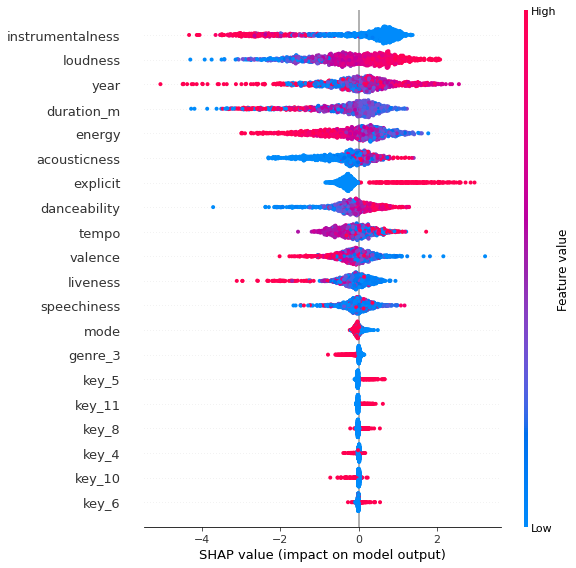

In [76]:
sample = X_test_transformed.iloc[:1000]
shap_values = explainer.shap_values(sample)

shap.initjs()
shap.summary_plot(
    shap_values=shap_values, 
    features=sample
)

👉 데시벨이 보다 높고, 노래의 긴장감 액티브함이 덜할수록, 가사에 자극적인 내용이 포함되고, 조금은 어쿠스틱하고, 댄스곡으로 어울리는 노래일수록 히트 칠 가능성이 높아짐을 알 수 있습니다. 또한 의외로 긍정적인 노래보다 sad, depressed 한 분위기의 노래일수록 인기가 많은데 이는 노래가 오히려 암울한 부분을 드러낼수록 유저가 슬픈 감성에 젖어들며 노래에 공감하거나 위로를 받을 수 있음을 유추할 수 있습니다. 더불어 노래의 시작이 단조인 것보다 장조일 때, 노래의 주요 Key 가 'F', 'B', 'G#', 'F#' 일수록 인기가 있을 가능성이 높아집니다. 반대로 주요 Key 가 'A#', 'E' 인 경우 인기가 있을 가능성이 떨어질 수 있음을 알 수 있습니다.

✔️ 추가적으로, 아티스트의 인기도 매우 중요한 특성이지만 프로젝트에 사용한 데이터에서 아티스트의 인기 데이터를 만드는 과정에 타겟 데이터 누수가 발생했습니다. 즉, 아티스트의 인기도를 알 수 있는 객관적인 지표를 나타내는 특성이 필요해 보입니다.



> 스포티파이에 등록된 음원 데이터를 기반으로 글로벌 뮤직 트렌드를 음악적인 특성들로 세분화해 파악할 수 있었습니다. 이후 분석한 트렌드를 참고해 **신곡 기획 및 작곡에 레퍼런스로 활용**할 수 있을 것으로 생각합니다. 또한 데모가 완성되면 노래에서 얻을 수 있는 데이터를 기반으로 모델을 통해 **노래가 글로벌 음악 시장에서 히트 칠 가능성이 있을지 예측**해 볼 수 있겠습니다. 

